Link of the dataset from Kaggle: https://www.kaggle.com/code/hanaelfar/medical-cost-prediction/input

# Regression Task

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/drive/MyDrive/AI Coursework/insurance.csv')


##Data Understanding and Exploratory Data Analysis

In [5]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
#identify the number of rows and columns in the dataset.

rows, cols = df.shape

print(f"Number of rows: {rows}, Number of columns: {cols}")

Number of rows: 1338, Number of columns: 7


In [8]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
print("\nDataset Information:")
df.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [10]:
#check for duplicate values
print(f"Total number of duplicated values in the dataset: {df.duplicated().sum()}")

Total number of duplicated values in the dataset: 1


In [11]:
# Drop duplicate rows
df.drop_duplicates(inplace=True)

# Verify if duplicates are removed
print(f"Total number of duplicated values in the dataset after dropping duplicates: {df.duplicated().sum()}")


Total number of duplicated values in the dataset after dropping duplicates: 0


In [12]:
# Check for missing values
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [13]:
print("Columns:")
print(df.columns)


Columns:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [14]:
# Select all categorical columns (columns with data type 'object') from the DataFrame
categoricalCol = df.select_dtypes(include='object')

# Select all numerical columns (columns with data type 'number') from the DataFrame
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns


##Visualization

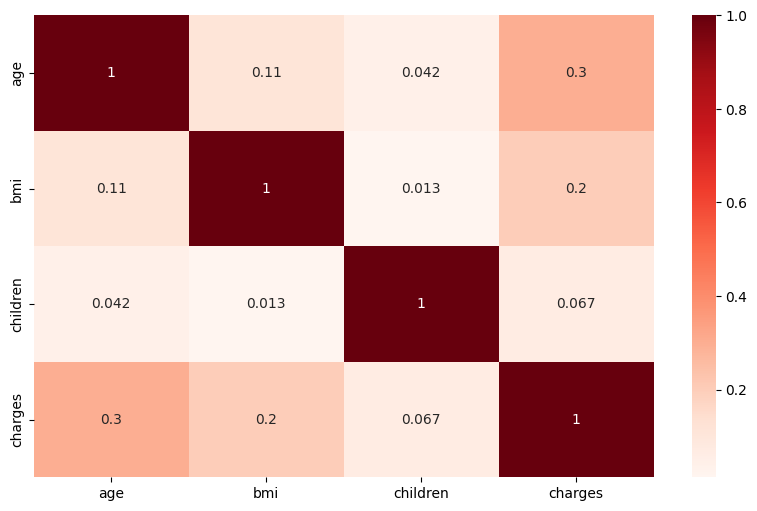

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerical_columns].corr(), annot=True, cmap='Reds')
plt.show()

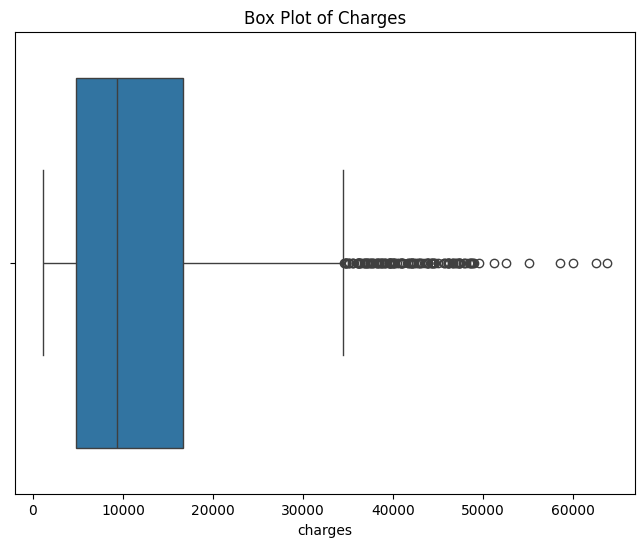

In [16]:
# Box plot of charges
plt.figure(figsize=(8, 6))
sns.boxplot(x='charges', data=df)
plt.title('Box Plot of Charges')
plt.show()


In [17]:
#Label encoding categorical values
label_encoder = LabelEncoder()
df['region'] = label_encoder.fit_transform(df['region'])
df['sex'] = label_encoder.fit_transform(df['sex'])
df['smoker'] = label_encoder.fit_transform(df['smoker'])

In [18]:

# Calculate the IQR for the 'charges' column
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove rows where 'charges' is an outlier
df = df[(df['charges'] >= lower_bound) & (df['charges'] <= upper_bound)]


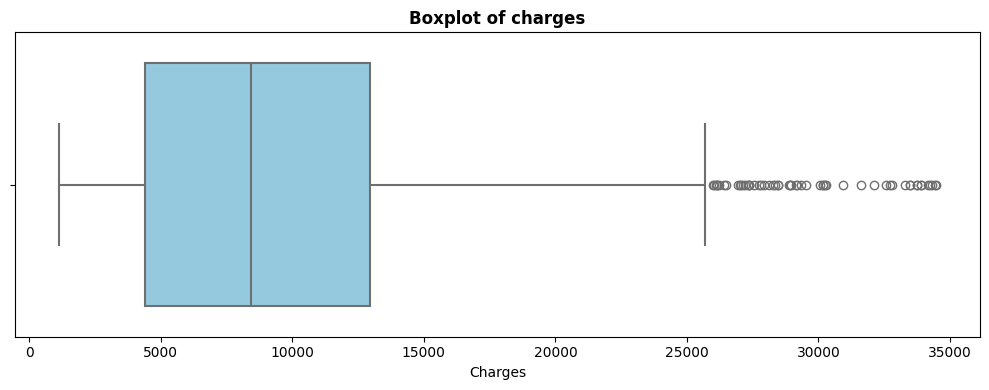

In [19]:
#boxplot after handling outlier
plt.figure(figsize=(10, 4))

sns.boxplot(x=df['charges'], color="skyblue", linewidth=1.5)

plt.title(f"Boxplot of charges", fontsize=12, fontweight="bold")
plt.xlabel("Charges", fontsize=10)

plt.tight_layout()
plt.show()


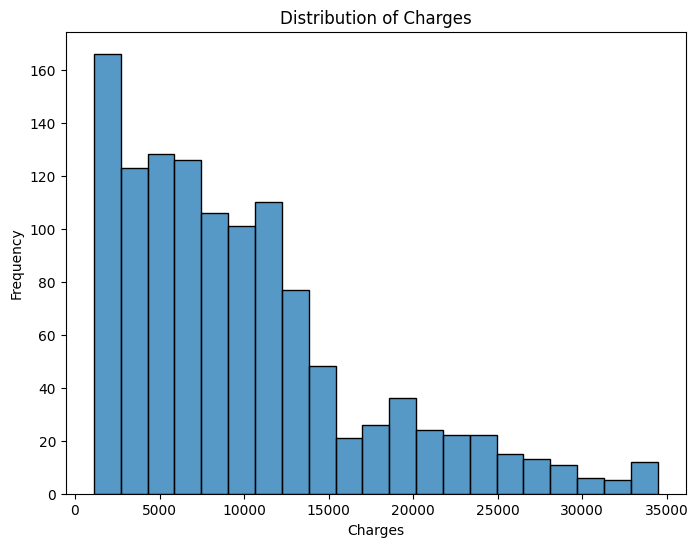

In [20]:
plt.figure(figsize=(8, 6))
sns.histplot(df['charges'])
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

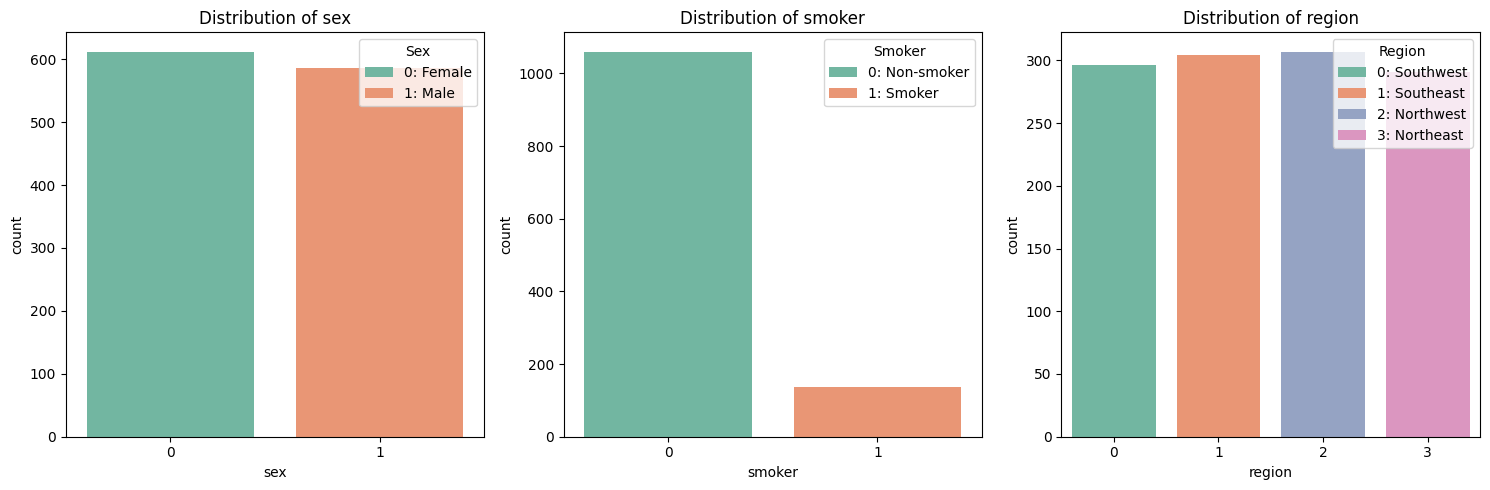

In [21]:
# categorical_features = ['sex', 'smoker', 'region']
# fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# for idx, col in enumerate(categorical_features):
#     sns.countplot(x=df[col], ax=axes[idx], palette="Set2")
#     axes[idx].set_title(f"Distribution of {col}")
# plt.tight_layout()
# plt.show()

categorical_features = ['sex', 'smoker', 'region']
legends = {
    'sex': {0: 'Female', 1: 'Male'},
    'smoker': {0: 'Non-smoker', 1: 'Smoker'},
    'region': {0: 'Southwest', 1: 'Southeast', 2: 'Northwest', 3: 'Northeast'}
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, col in enumerate(categorical_features):
    sns.countplot(x=df[col], ax=axes[idx], palette="Set2")
    axes[idx].set_title(f"Distribution of {col}")

    # Add legend for each categorical feature
    legend_labels = [f"{k}: {v}" for k, v in legends[col].items()]
    axes[idx].legend(legend_labels, title=col.capitalize(), loc='upper right')

plt.tight_layout()
plt.show()

##Splitting Dataset into training and testing sets.

In [22]:
#splitting the data into features and target variable

X=df.drop(['charges'],axis=1)
y=df['charges']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##Model From Scratch

Here, we will implement the linear regression model with gradient descent from scratch, updating the model parameters iteratively to minimize the cost function (MSE). Gradient descent is used to find the optimal values for the weights and bias, allowing the model to make better predictions.

In [25]:
def compute_costfunction(X, y, w, b):
    m = len(y)
    y_pred = np.dot(X, w) + b
    cost = np.sum((y_pred - y) ** 2) / (2 * m)  # MSE / 2
    return cost

def compute_gradient(X, y, w, b):
    m = len(y)
    y_pred = np.dot(X, w) + b
    error = y_pred - y
    grad_w = np.dot(X.T, error) / m  # Gradient of weights
    grad_b = np.sum(error) / m  # Gradient of bias
    return grad_w, grad_b

def gradient_descent(X, y, w, b, alpha, n_iter):
    cost_history = []
    for i in range(n_iter):
        grad_w, grad_b = compute_gradient(X, y, w, b)

        # w and b are updated at each step by subtracting the gradient multiplied by the learning rate (alpha).
        w -= alpha * grad_w
        b -= alpha * grad_b
        if i % 100 == 0:
            cost = compute_costfunction(X, y, w, b)
            cost_history.append(cost)
            print(f"Iteration {i}: Cost = {cost:.4f}")
    return w, b, cost_history

In [26]:
# Initialize parameters
n_features = X_train_scaled.shape[1]
w_initial = np.zeros(n_features)
b_initial = 0.0
alpha = 0.01  # Learning rate
n_iter = 1000  # Number of iterations

In [27]:
# Train the model using gradient descent
w_final, b_final, cost_history = gradient_descent(X_train_scaled, y_train, w_initial, b_initial, alpha, n_iter)


Iteration 0: Cost = 72894724.4590
Iteration 100: Cost = 18920182.0781
Iteration 200: Cost = 11390087.6123
Iteration 300: Cost = 10312166.8110
Iteration 400: Cost = 10153018.6866
Iteration 500: Cost = 10128559.0438
Iteration 600: Cost = 10124601.6547
Iteration 700: Cost = 10123920.8240
Iteration 800: Cost = 10123795.6434
Iteration 900: Cost = 10123771.1013


In [28]:
# Make predictions
y_train_pred = np.dot(X_train_scaled, w_final) + b_final
y_test_pred = np.dot(X_test_scaled, w_final) + b_final

In [29]:
# Compute evaluation metrics
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

In [30]:
print("\nModel Evaluation:")
print("For Training set:")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train R²: {r2_train:.4f}")


Model Evaluation:
For Training set:
Train MSE: 20247532.0746
Train R²: 0.6103


In [31]:
print("\nFor Test set:")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test R²: {r2_test:.4f}")


For Test set:
Test MSE: 22883735.7705
Test R²: 0.5746


#Building Primary Model

##Model 1:  Linear Regression

In [32]:
model = LinearRegression()
# Train the model on the training data
model.fit(X_train, y_train)

LinearRegression()

In [33]:
# make predictions with the trained linear regression model

y_predtest = model.predict(X_test)
y_predtrain = model.predict(X_train)

In [34]:

mse = mean_squared_error(y_train, y_predtrain)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_predtrain)
print("Linear Regression model:")
print(f'For Training set:\nMean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²): {r2:.4f}')


Linear Regression model:
For Training set:
Mean Squared Error (MSE): 20247529.1928
Root Mean Squared Error (RMSE): 4499.7255
R-squared (R²): 0.6103


In [35]:

mse = mean_squared_error(y_test, y_predtest)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predtest)
print("Linear Regression model:")
print(f'Test:\nMean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'R-squared (R²): {r2:.4f}')

Linear Regression model:
Test:
Mean Squared Error (MSE): 22885929.4820
Root Mean Squared Error (RMSE): 4783.9241
R-squared (R²): 0.5746


##Model 2: Random Forest Regressor

In [36]:
#Initialize and train the model
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [37]:
#predict
y_predtest_rf = rf_reg.predict(X_test)
y_predtrain_rf = rf_reg.predict(X_train)

In [38]:
#calculate the evaluation metrics for train set
mae_rf = mean_absolute_error(y_train, y_predtrain_rf)
mse_rf = mean_squared_error(y_train, y_predtrain_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_train, y_predtrain_rf)


In [39]:
print("\nRandom Forest Regressor Performance on Training Set:")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")


Random Forest Regressor Performance on Training Set:
MAE: 936.5138
MSE: 3111686.4839
RMSE: 1763.9973
R-squared: 0.9401


In [40]:
#calculate the evaluation metrics for test set
mae_rf = mean_absolute_error(y_test, y_predtest_rf)
mse_rf = mean_squared_error(y_test, y_predtest_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_predtest_rf)

In [41]:
print("\nRandom Forest Regressor Performance on Test:")
print(f"MAE: {mae_rf:.4f}")
print(f"MSE: {mse_rf:.4f}")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R-squared: {r2_rf:.4f}")


Random Forest Regressor Performance on Test:
MAE: 2550.4697
MSE: 23032609.4642
RMSE: 4799.2301
R-squared: 0.5718


####The Random Forest Regressor outperformed Linear Regression, achieving lower errors (MSE, RMSE, MAE) and higher R-squared (0.8493 vs. 0.8207) on the test set. It captured patterns better but slightly overfitted the training data. Overall, Random Forest is superior

#Hyperparameter Optimization

##Hyperparameter Optimization: Linear Regression

In [42]:
#Hyperparameter Tuning: Linear Regression (Ridge)
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Regularization strength
ridge = Ridge()

In [43]:
grid_ridge = GridSearchCV(ridge, ridge_params, scoring='r2', cv=5)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]}, scoring='r2')

In [44]:
best_ridge = grid_ridge.best_estimator_
print("\nBest Linear Regression Hyperparameters:", grid_ridge.best_params_)


Best Linear Regression Hyperparameters: {'alpha': 1}


##Hyperparameter Optimization: Random Forest Regressor

In [45]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, scoring='r2', cv=5)
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='r2')

In [46]:
best_rf = grid_rf.best_estimator_
print("\nBest Random Forest Hyperparameters:", grid_rf.best_params_)


Best Random Forest Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


#Feature selection

##Feature Selection: Linear Regression

In [47]:
# Feature Selection of Ridge regression by Recursive Feature Elimination(RFE)

rfe_selector = RFE(best_ridge, n_features_to_select=5)  # Select top 5 features
rfe_selector.fit(X_train, y_train)

# Get selected features
selected_features_ridge = X_train.columns[rfe_selector.support_].tolist()

print("\nSelected Features for Ridge Regression:", selected_features_ridge)



Selected Features for Ridge Regression: ['age', 'sex', 'children', 'smoker', 'region']


##Feature Selection: Random Forest Regressor

In [48]:
#Feature Selection: Random Forest (Feature Importance)
feature_importances = best_rf.feature_importances_

# Create a DataFrame with Features and Their Importances:
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

selected_features_rf = feature_importance_df.nlargest(5, 'Importance')['Feature'].tolist()  # Top 5

print("\nSelected Features for Random Forest:", selected_features_rf)


Selected Features for Random Forest: ['smoker', 'age', 'bmi', 'children', 'region']


#Final Model(Random Forest Regressor) After Hyperparameter Optimization and Hyperparameter Tuning

In [49]:
# Select Features for Training and Testing:
X_train_rf = X_train[selected_features_rf]
X_test_rf = X_test[selected_features_rf]

In [50]:
# Train the Final Random Forest Model using best hyperparams:
final_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42)
final_rf.fit(X_train_rf, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=42)

In [51]:
#make predictions
y_predtest_rf_final = final_rf.predict(X_test_rf)
y_predtrain_rf_final = final_rf.predict(X_train_rf)

In [52]:
#Calculate and print performance metrics for train sets
mae_rf_train_final = mean_absolute_error(y_train, y_predtrain_rf_final)
mse_rf_train_final = mean_squared_error(y_train, y_predtrain_rf_final)
rmse_rf_train_final = np.sqrt(mse_rf)
r2_rf_train_final = r2_score(y_train, y_predtrain_rf_final)

print("\nFinal Random Forest Performance for Train set:")
print(f"MAE: {mae_rf_train_final:.4f}")
print(f"MSE: {mse_rf_train_final:.4f}")
print(f"RMSE: {rmse_rf_train_final:.4f}")
print(f"R-squared: {r2_rf_train_final:.4f}")


Final Random Forest Performance for Train set:
MAE: 1782.4951
MSE: 11450762.4409
RMSE: 4799.2301
R-squared: 0.7796


In [53]:
#Calculate and print performance metrics for test sets
mae_rf_test_final = mean_absolute_error(y_test, y_predtest_rf_final)
mse_rf_test_final = mean_squared_error(y_test, y_predtest_rf_final)
rmse_rf_test_final = np.sqrt(mse_rf_test_final)
r2_rf_test_final = r2_score(y_test, y_predtest_rf_final)

print("\nFinal Random Forest Performance for Test set:")
print(f"MAE: {mae_rf_test_final:.4f}")
print(f"MSE: {mse_rf_test_final:.4f}")
print(f"RMSE: {rmse_rf_test_final:.4f}")
print(f"R-squared: {r2_rf_test_final:.4f}")



Final Random Forest Performance for Test set:
MAE: 2406.7562
MSE: 21623609.1674
RMSE: 4650.1193
R-squared: 0.5980


#Conclusion:

The final Random Forest Regressor model performs well, with R-squared: 0.8746 (train) and 0.8719 (test), indicating strong generalization. MAE (2012.65) and RMSE (3869.18) on the test set show accurate predictions. The small gap between train and test errors suggests the model balances performance and generalization effectively.